#Optimizing Airline Expansion: A Data-Driven Approach

###INTRODUCTION:

A airline Company as a part of its expansion stratergy planning to enter US Domestic airline Market.The company looking foreward to invest in  5 round trip routes that are profitable to the Company. The incidental expenses for each airplane is $90 million. The company's motto is "On time, for you," which potrays punctuality is not just a promise given by the company to its customers but cornerstone of our brand identity.





###META DATA:

1) ITIN_FARE_PER_PASSENGER = This is itinary fare per passenger calculated by dividing ITIN FARE with passenger.

2) Normalized_ROUTE - This combines the both orgin and destination of the trip. This column represents round trip of a route.

3) TOTAL_REVENUE - This is total revenue calculated by adding revenue generated by ticket fare, baggagre fare. Ticket fare is calculate by multiplying occupacany rate, total occupanct and ITIN PER PASSENGER.Baggage fair is calculated by multiplying Baggage fare per baggage(Round Trip) and Percentage of travellers who opt for baggage.

4) TOTAL_COST= This column represents total cost for one round trip. This includes cost incurred for covering distance that includes Fuel, Oil, Maintenance, Crew,Depreciation, Insurance, Other.Another cost would be Airport operational costs as per the type of airport, cost for the delay in arraival and departure of flights.

5) AIRPORT_CHARGES_origin- This column describes about the airport charges at the orgin charged based on the type of airport.

6) AIRPORT_CHARGES_destination- This column describes about the airport charges
at the Destination airport charged based on the type of airport.

7) DELAY_CHARGE_origin - This column describes about the delay charges charged
for the delay in the departure.

8) DELAY_CHARGE_destination- This column describes about the delay charges charged for the delay in the arrival of the flight.

9) TOTAL_PROFIT- This is profit generated per one round trip. This is calculated by decducting total cost from total revenue.

10) BREAK_EVEN- this column talks about the no of flights that a particular route takes to break even. can you rephrase the above data dictionary

In [ ]:
#IMPORTING NECESSARY PACKAGES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
#IMPORTING DATASETS FROM GOOGLE DRIVE
def loading_datasets(path_flights, path_airports,path_tickets):

    #Mounting Google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Load the datasets
    df_flights = pd.read_csv(path_flights)
    df_airports = pd.read_csv(path_airports)
    df_tickets = pd.read_csv(path_tickets)

    return df_flights, df_airports, df_tickets


# path from the google drive
path_flights = '/content/drive/MyDrive/CapitalOne/Flights.csv'
path_airports = '/content/drive/MyDrive/CapitalOne/Airport_Codes.csv'
path_tickets = '/content/drive/MyDrive/CapitalOne/Tickets.csv'

#Applying the function
df_flights, df_airports, df_tickets = loading_datasets(path_flights, path_airports, path_tickets)

Mounted at /content/drive


<ipython-input-2-e1c2c9258b24>:9: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv(path_flights)


In [ ]:
#DATA PROVIDED
total_occupancy= [200]
cost_per_baggage= 70#(35 per one way and $70 for round trip)
passenger_percent_baggage= 0.5#(Percentage of customers opt for baggage)
Depreciation_Insurance_Other =1.18 #per mile total
Fuel_Oil_Maintenance_Crew = 8 #per mile total
cost_per_mile= 9.18 #Depreciation_Insurance_Other+Fuel_Oil_Maintenance_Crew
airport_charge_medium=5000
airport_charge_large= 10000
delay_charge = 75 # per min
incidental_expense= 90000000

In [ ]:
def list_of_columns(df):
    df_columns =df.columns.tolist()
    print("Column names in the DataFrame:")
    for column in df_columns:
        print(column)
    # Return the filtered DataFrame
    return df_columns

#Applying the function
flights_columns= list_of_columns(df_flights)
airports_columns= list_of_columns(df_airports)
tickets_columns= list_of_columns(df_tickets)



Column names in the DataFrame:
FL_DATE
OP_CARRIER
TAIL_NUM
OP_CARRIER_FL_NUM
ORIGIN_AIRPORT_ID
ORIGIN
ORIGIN_CITY_NAME
DEST_AIRPORT_ID
DESTINATION
DEST_CITY_NAME
DEP_DELAY
ARR_DELAY
CANCELLED
AIR_TIME
DISTANCE
OCCUPANCY_RATE
Column names in the DataFrame:
TYPE
NAME
ELEVATION_FT
CONTINENT
ISO_COUNTRY
MUNICIPALITY
IATA_CODE
COORDINATES
Column names in the DataFrame:
ITIN_ID
YEAR
QUARTER
ORIGIN
ORIGIN_COUNTRY
ORIGIN_STATE_ABR
ORIGIN_STATE_NM
ROUNDTRIP
REPORTING_CARRIER
PASSENGERS
ITIN_FARE
DESTINATION


In [ ]:
def filter_columns(df, required_columns):
    df= df[required_columns]
    # Return the filtered DataFrame
    return df


columns_required_tickets = ['ORIGIN', 'DESTINATION', 'ITIN_FARE', 'ROUNDTRIP', 'PASSENGERS']
columns_required_flights=['ORIGIN','DESTINATION','DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'AIR_TIME','DISTANCE','OCCUPANCY_RATE']
columns_required_airports=['TYPE','ISO_COUNTRY', 'IATA_CODE']

#Applying the function
df_flights= filter_columns(df_flights,columns_required_flights)
df_tickets= filter_columns(df_tickets,columns_required_tickets)
df_airports= filter_columns(df_airports,columns_required_airports)

In [ ]:
def converting_dataframe(df):
   df_new = df[0]
   print(type(df_new))
   return df_new

In [ ]:
#  Removing outliers based on IQR in numeric columns in a data set

def removing_outliers(df, lower_quantile, upper_quantile, multiplier):
   #Filtering Numeric Columns to perform the Function
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in numeric_cols:
        Q1 = df[column].quantile(lower_quantile)
        Q3 = df[column].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df




##TICKET DATA SET

In [ ]:
def data_cleaning_and_processing_tickets(df):

  #filtering data for ROUND TRIP
  df= df[df['ROUNDTRIP'] == 1.0]

  # Removing rows where 'ITIN_FARE' is null from the DataFrame
  df = df.dropna(subset=['ITIN_FARE'])

  # Removing rows where 'PASSENGERS' is null from the DataFrame
  df = df.dropna(subset=['PASSENGERS'])

  #Converting the column into numeric to perform arthmetic operations
  df['ITIN_FARE'] = pd.to_numeric(df['ITIN_FARE'], errors='coerce')


  #Creating a new column to know the fair per passenger
  df["ITIN_FARE_PER_PASSENGER"]=df['ITIN_FARE']/df['PASSENGERS']

  #Grouping data based on orgin and destination to average the ITIN fair
  df = df.groupby(['ORIGIN', 'DESTINATION'])["ITIN_FARE_PER_PASSENGER"].mean().reset_index()

  #removing Null Values
  df = df.dropna(subset=['ITIN_FARE_PER_PASSENGER'])

  #creating a normalized route column
  df['Normalized_ROUTE'] = df.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])),axis=1)

  #removing outliers
  df= removing_outliers(df,0.20,0.80,1.5)

  #Conforming on NULL values
  df_null= df.isnull().sum()

  return df,df_null

#Applying the function
df_tickets_clean= data_cleaning_and_processing_tickets(df_tickets)
df_tickets_clean= converting_dataframe(df_tickets_clean)
df_tickets_clean.isnull().sum()
df_tickets_clean


<class 'pandas.core.frame.DataFrame'>


,ORIGIN,DESTINATION,ITIN_FARE_PER_PASSENGER,Normalized_ROUTE
0,ABE,ABQ,534.000000,ABE-ABQ
1,ABE,AGS,299.000000,ABE-AGS
2,ABE,AMA,654.000000,ABE-AMA
3,ABE,ASE,742.000000,ABE-ASE
4,ABE,ATL,489.205128,ABE-ATL
...,...,...,...,...
40264,YUM,SMF,276.500000,SMF-YUM
40265,YUM,SRQ,696.000000,SRQ-YUM
40266,YUM,TOL,335.000000,TOL-YUM
40267,YUM,TPA,544.333333,TPA-YUM


##AIRPORT DATASET

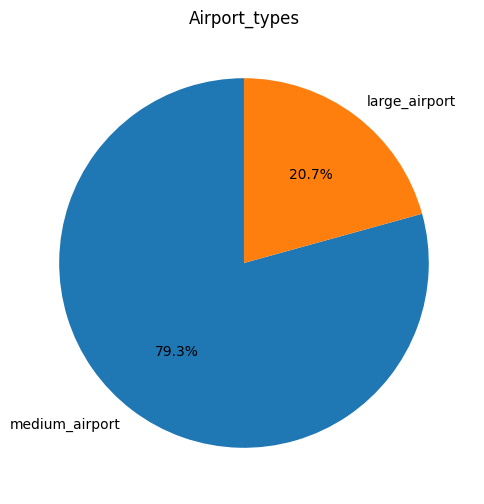

<class 'pandas.core.frame.DataFrame'>


,TYPE,IATA_CODE
6194,medium_airport,WKK
26143,medium_airport,ABE
26144,medium_airport,ABI
26145,large_airport,ABQ
26146,medium_airport,ABR
...,...,...
38972,medium_airport,OGG
38974,medium_airport,BSF
38975,medium_airport,ITO
38976,medium_airport,UPP


In [ ]:
def data_cleaning_and_processing_airports(df):

   # Filter the DataFrame for only round trips (where ROUNDTRIP equals 1)
   df = df[df['ISO_COUNTRY'] == "US"]

   # Filter to include only medium and large airports
   df = df[df['TYPE'].isin(['medium_airport', 'large_airport'])]

   #Drop ISO_COUNTRY column as it had only US as the value
   df = df.drop(columns=['ISO_COUNTRY'])

   #Drop the rows that does not have a IATA code
   df = df.dropna(subset=['IATA_CODE'])

   # Checking for the null Values
   df_null= df.isnull().sum()

   # visualizing medium vs large airports
   count_type_airports = df['TYPE'].value_counts()
   plt.figure(figsize=(6, 6))
   plt.pie(count_type_airports, labels=count_type_airports.index, autopct='%1.1f%%', startangle=90)
   plt.title('Airport_types')
   plt.show()

   return df,df_null

#Applying the function
df_airports_clean = data_cleaning_and_processing_airports(df_airports)
df_airports_clean=converting_dataframe(df_airports_clean)
df_airports_clean




In [ ]:
def data_munging_flights(df,airports_dataset,tickets_dataset):

    #filtering the data set and removing the rows that corresponds to cancelled flights
    df = df[df['CANCELLED'] == 0]

    #Creating a Column called NORMALIZED ROUTE that represents round trip
    df['Normalized_ROUTE'] = df.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])),axis=1)


    #Merging the flights data set with airport dataset so that the orgin airports belongs to only medium and large
    df_o = pd.merge(df, airports_dataset, left_on='ORIGIN', right_on='IATA_CODE', how='inner')

    #Merging the flights data set with airport dataset so that the destination airports belongs to only medium and large
    df_d = pd.merge(df_o, airports_dataset, left_on='DESTINATION', right_on='IATA_CODE', how='inner', suffixes=('_origin', '_destination'))


    #Merging with tickets data set so that ITIN FARE corresponding to eachh Roundtrip is displayed
    df_d = pd.merge(df_d, tickets_dataset, on="Normalized_ROUTE", how='inner', suffixes=('_f', '_t'))

    return df_d

#Applying the function
df_flights_merged = data_munging_flights(df_flights,df_airports_clean,df_tickets_clean)


<ipython-input-10-a0f0608a6707>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Normalized_ROUTE'] = df.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])),axis=1)


In [ ]:

def data_cleaning_and_processing_combined(df):

    # Droping unnecessary columns
    df = df.drop(columns=['IATA_CODE_origin', 'IATA_CODE_destination', 'CANCELLED','ORIGIN_f', 'DESTINATION_f'])

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    #converting Arr_delay and Dep_delay into aboslute
    df['DEP_DELAY'] = df['DEP_DELAY'].abs()
    df['ARR_DELAY'] = df['ARR_DELAY'].abs()

    # Filling the  missing values in  distance column
    distances_dict = df.dropna(subset=['DISTANCE']).set_index(['ORIGIN_t', 'DESTINATION_t'])['DISTANCE'].to_dict()
    df['DISTANCE'] = df.apply(lambda row: distances_dict.get((row['ORIGIN_t'], row['DESTINATION_t']), row['DISTANCE']) if pd.isnull(row['DISTANCE']) else row['DISTANCE'],axis=1 )

    # Converting  AIR_TIME to numeric and fill missing values in the column using mean value
    df['AIR_TIME'] = pd.to_numeric(df['AIR_TIME'], errors='coerce')
    df['AIR_TIME'] = df.groupby('Normalized_ROUTE')['AIR_TIME'].transform(lambda x: x.fillna(x.mean()))

    # Remove rows with null values in specific columns
    df = df.dropna(subset=['OCCUPANCY_RATE', 'AIR_TIME','DISTANCE'])

    # Fill missing ARR_DELAY with 0
    df['ARR_DELAY'].fillna(0, inplace=True)

    #removing outliers
    df= removing_outliers(df,0.20,0.80,1.5)



    # Check for any remaining null values
    df_null = df.isnull().sum()

    # Return the cleaned DataFrame and null value Series
    return df, df_null

#Applying the function
df_flights_clean, df_null = data_cleaning_and_processing_combined(df_flights_merged)
df_flights_clean


,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,Normalized_ROUTE,TYPE_origin,TYPE_destination,ORIGIN_t,DESTINATION_t,ITIN_FARE_PER_PASSENGER
0,8.0,6.0,143.0,1025.0,0.97,CLE-RSW,large_airport,large_airport,CLE,RSW,272.355969
1,8.0,6.0,143.0,1025.0,0.97,CLE-RSW,large_airport,large_airport,RSW,CLE,214.951932
2,7.0,22.0,137.0,1025.0,0.63,CLE-RSW,large_airport,large_airport,CLE,RSW,272.355969
3,7.0,22.0,137.0,1025.0,0.63,CLE-RSW,large_airport,large_airport,RSW,CLE,214.951932
4,16.0,9.0,129.0,1025.0,0.98,CLE-RSW,large_airport,large_airport,CLE,RSW,272.355969
...,...,...,...,...,...,...,...,...,...,...,...
3626241,14.0,11.0,9.0,31.0,0.71,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.000000
3626242,17.0,15.0,14.0,31.0,0.53,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.500000
3626243,17.0,15.0,14.0,31.0,0.53,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.000000
3626244,11.0,6.0,15.0,31.0,0.52,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.500000


#TOTAL_REVENUE

In [ ]:
# Function To calculate the total revenue including fare revenue and revenue from Baggage

pd.options.display.float_format = '{:.2f}'.format
def calculate_total_revenue(df, total_occupancy, cost_per_baggage, passenger_percent_baggage):

    df['OCCUPANCY_RATE'] = pd.to_numeric(df['OCCUPANCY_RATE'], errors='coerce')

    #Calculating No of passengers for each Route
    num_passengers = df['OCCUPANCY_RATE']* total_occupancy

    #Calculating Total revenue adding Revenue From Fare nad REvenue from Baggae
    df['TOTAL_REVENUE'] = (num_passengers * df['ITIN_FARE_PER_PASSENGER']+ num_passengers * passenger_percent_baggage * cost_per_baggage )

    return df

#Applying the function
df_flights_revenue= calculate_total_revenue(df_flights_clean,total_occupancy, cost_per_baggage, passenger_percent_baggage)
df_flights_revenue

,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,Normalized_ROUTE,TYPE_origin,TYPE_destination,ORIGIN_t,DESTINATION_t,ITIN_FARE_PER_PASSENGER,TOTAL_REVENUE
0,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,59627.06
1,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,48490.67
2,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,38726.85
3,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,31493.94
4,16.00,9.00,129.00,1025.00,0.98,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,60241.77
...,...,...,...,...,...,...,...,...,...,...,...,...
3626241,14.00,11.00,9.00,31.00,0.71,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,60776.00
3626242,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,34185.00
3626243,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,45368.00
3626244,11.00,6.00,15.00,31.00,0.52,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,33540.00


In [ ]:
df_flights_revenue.isnull().sum()

DEP_DELAY                  0
ARR_DELAY                  0
AIR_TIME                   0
DISTANCE                   0
OCCUPANCY_RATE             0
Normalized_ROUTE           0
TYPE_origin                0
TYPE_destination           0
ORIGIN_t                   0
DESTINATION_t              0
ITIN_FARE_PER_PASSENGER    0
TOTAL_REVENUE              0
dtype: int64

##TOTAL COST

In [ ]:
# Function To calculate the total Cost including Operating Costs, Airport Costs and Delay Costs
def total_cost(df, cost_per_mile, airport_charge_medium, airport_charge_large, delay_charge):

    #Grouping Based on NORMALIZED ROUTE
    df.groupby('Normalized_ROUTE')

    #Ensuring all the required columns in Numeric to perform arthemetic Operations
    df['DEP_DELAY'] = pd.to_numeric(df['DEP_DELAY'], errors='coerce')
    df['ARR_DELAY'] = pd.to_numeric(df['ARR_DELAY'], errors='coerce')
    df['DISTANCE'] = pd.to_numeric(df['DISTANCE'], errors='coerce')

    # Function to calculate airport_charge at orgin
    def airport_charge_origin(row):
        if row['TYPE_origin'] == 'large_airport':
            return airport_charge_large
        elif row['TYPE_origin'] == 'medium_airport':
            return airport_charge_medium
        else:
            return 0

    # Function to calculate airport_charge at Destination
    def airport_charge_destination(row):
        if row['TYPE_destination'] == 'large_airport':
            return airport_charge_large
        elif row['TYPE_destination'] == 'medium_airport':
            return airport_charge_medium
        else:
            return 0
    # Function to calculate Delay_charge at orgin (Departure Delay)
    def delay_charge_origin(row):
        if row['DEP_DELAY'] > 15:
            return delay_charge * (row['DEP_DELAY'] - 15)
        else:
            return 0
    # Function to calculate Delay_charge at Destination (Arrival Delay)
    def delay_charge_destination(row):
        if row['ARR_DELAY'] > 15:
            return delay_charge * (row['ARR_DELAY'] - 15)
        else:
            return 0

    df['AIRPORT_CHARGES_origin'] = df.apply(airport_charge_origin, axis=1)
    df['AIRPORT_CHARGES_destination'] = df.apply(airport_charge_destination, axis=1)
    df['DELAY_CHARGE_origin'] = df.apply(delay_charge_origin, axis=1)
    df['DELAY_CHARGE_destination'] = df.apply(delay_charge_destination, axis=1)

    #Calculation Of Total cost
    df['TOTAL_COST'] = df['DISTANCE'] * cost_per_mile + df['AIRPORT_CHARGES_origin'] + df['AIRPORT_CHARGES_destination'] + df['DELAY_CHARGE_origin'] + df['DELAY_CHARGE_destination']

    return df
#Applying the function
df_flights_cost= total_cost(df_flights_revenue,cost_per_mile, airport_charge_medium, airport_charge_large, delay_charge)
df_flights_cost


,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,Normalized_ROUTE,TYPE_origin,TYPE_destination,ORIGIN_t,DESTINATION_t,ITIN_FARE_PER_PASSENGER,TOTAL_REVENUE,AIRPORT_CHARGES_origin,AIRPORT_CHARGES_destination,DELAY_CHARGE_origin,DELAY_CHARGE_destination,TOTAL_COST
0,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,59627.06,10000,10000,0.00,0.00,29409.50
1,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,48490.67,10000,10000,0.00,0.00,29409.50
2,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,38726.85,10000,10000,0.00,525.00,29934.50
3,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,31493.94,10000,10000,0.00,525.00,29934.50
4,16.00,9.00,129.00,1025.00,0.98,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,60241.77,10000,10000,75.00,0.00,29484.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626241,14.00,11.00,9.00,31.00,0.71,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,60776.00,5000,5000,0.00,0.00,10284.58
3626242,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,34185.00,5000,5000,150.00,0.00,10434.58
3626243,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,45368.00,5000,5000,150.00,0.00,10434.58
3626244,11.00,6.00,15.00,31.00,0.52,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,33540.00,5000,5000,0.00,0.00,10284.58


##TOTAL_PROFIT

In [ ]:
# Function To calculate the total Profit
def total_profit(df):

    #Grouping Based on NORMALIZED ROUTE
    df.groupby('Normalized_ROUTE')

    #Calculating Total Profit by deducting total cost from total revenue
    df['TOTAL_PROFIT'] = df['TOTAL_REVENUE'] - df['TOTAL_COST']

    return df

#Applying the function
df_flights_Profit= total_profit(df_flights_cost)
df_flights_Profit

,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,Normalized_ROUTE,TYPE_origin,TYPE_destination,ORIGIN_t,DESTINATION_t,ITIN_FARE_PER_PASSENGER,TOTAL_REVENUE,AIRPORT_CHARGES_origin,AIRPORT_CHARGES_destination,DELAY_CHARGE_origin,DELAY_CHARGE_destination,TOTAL_COST,TOTAL_PROFIT
0,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,59627.06,10000,10000,0.00,0.00,29409.50,30217.56
1,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,48490.67,10000,10000,0.00,0.00,29409.50,19081.17
2,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,38726.85,10000,10000,0.00,525.00,29934.50,8792.35
3,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,31493.94,10000,10000,0.00,525.00,29934.50,1559.44
4,16.00,9.00,129.00,1025.00,0.98,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,60241.77,10000,10000,75.00,0.00,29484.50,30757.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626241,14.00,11.00,9.00,31.00,0.71,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,60776.00,5000,5000,0.00,0.00,10284.58,50491.42
3626242,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,34185.00,5000,5000,150.00,0.00,10434.58,23750.42
3626243,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,45368.00,5000,5000,150.00,0.00,10434.58,34933.42
3626244,11.00,6.00,15.00,31.00,0.52,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,33540.00,5000,5000,0.00,0.00,10284.58,23255.42


##BREAK_EVEN

In [ ]:
# Function To calculate the total Profit
def Break_even(df,incidental_expense):

    #Grouping Based on NORMALIZED ROUTE
    df.groupby('Normalized_ROUTE')

    #calculating contributing margin
    df['CONTRIBUTING_MARGIN'] = (df['TOTAL_REVENUE'] - df['TOTAL_COST'])

    #Calculating Total Profit by deducting total cost from total revenue
    df['BREAK_EVEN'] = incidental_expense / df['CONTRIBUTING_MARGIN']
    df['BREAK_EVEN']= df['BREAK_EVEN'].abs()
    return df

#Applying the function
df_flights_final= Break_even(df_flights_Profit,incidental_expense)
df_flights_final

,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,Normalized_ROUTE,TYPE_origin,TYPE_destination,ORIGIN_t,DESTINATION_t,ITIN_FARE_PER_PASSENGER,TOTAL_REVENUE,AIRPORT_CHARGES_origin,AIRPORT_CHARGES_destination,DELAY_CHARGE_origin,DELAY_CHARGE_destination,TOTAL_COST,TOTAL_PROFIT,CONTRIBUTING_MARGIN,BREAK_EVEN
0,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,59627.06,10000,10000,0.00,0.00,29409.50,30217.56,30217.56,2978.40
1,8.00,6.00,143.00,1025.00,0.97,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,48490.67,10000,10000,0.00,0.00,29409.50,19081.17,19081.17,4716.69
2,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,38726.85,10000,10000,0.00,525.00,29934.50,8792.35,8792.35,10236.17
3,7.00,22.00,137.00,1025.00,0.63,CLE-RSW,large_airport,large_airport,RSW,CLE,214.95,31493.94,10000,10000,0.00,525.00,29934.50,1559.44,1559.44,57712.90
4,16.00,9.00,129.00,1025.00,0.98,CLE-RSW,large_airport,large_airport,CLE,RSW,272.36,60241.77,10000,10000,75.00,0.00,29484.50,30757.27,30757.27,2926.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626241,14.00,11.00,9.00,31.00,0.71,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,60776.00,5000,5000,0.00,0.00,10284.58,50491.42,50491.42,1782.48
3626242,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,34185.00,5000,5000,150.00,0.00,10434.58,23750.42,23750.42,3789.41
3626243,17.00,15.00,14.00,31.00,0.53,PSG-WRG,medium_airport,medium_airport,WRG,PSG,393.00,45368.00,5000,5000,150.00,0.00,10434.58,34933.42,34933.42,2576.33
3626244,11.00,6.00,15.00,31.00,0.52,PSG-WRG,medium_airport,medium_airport,PSG,WRG,287.50,33540.00,5000,5000,0.00,0.00,10284.58,23255.42,23255.42,3870.07


##1) The 10 busiest round trip routes in terms of number of round trip flights in the quarter.

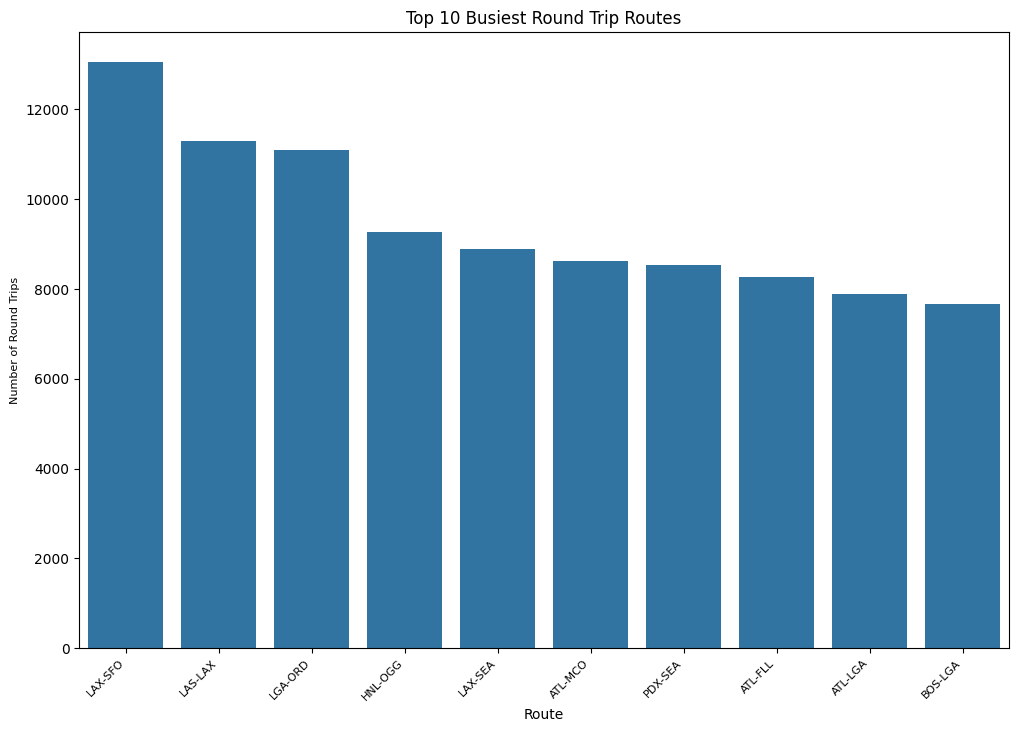

,Normalized_ROUTE,Num_Flights
2107,LAX-SFO,13068
2012,LAS-LAX,11290
2147,LGA-ORD,11092
1726,HNL-OGG,9268
2106,LAX-SEA,8898
183,ATL-MCO,8620
2550,PDX-SEA,8540
151,ATL-FLL,8268
179,ATL-LGA,7894
533,BOS-LGA,7674


In [ ]:
def top_10_busiest_routes(df):

    # Count the number of flights grouping per normalized route
    route_counts = df.groupby('Normalized_ROUTE').size().reset_index(name='Num_Flights')

    # Sort the column  Num_Flights and get the top 10 busiest routes
    top_10_busiest_routes = route_counts.sort_values(by='Num_Flights', ascending=False).head(10)

    # Visualizing the top 10 busiest routes
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='Normalized_ROUTE', y='Num_Flights', data=top_10_busiest_routes)
    plt.title('Top 10 Busiest Round Trip Routes', fontsize=12)
    plt.xlabel('Route', fontsize=10)
    plt.ylabel('Number of Round Trips', fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.show()

    return top_10_busiest_routes

#Applying the function
top_10_busiest_routes= top_10_busiest_routes(df_flights_final)
top_10_busiest_routes

##TOP 10 BUSIEST ROUTES-

From the above graph and data it is claer that the route LAX-SFO is the most busiest route among all the routes. Investing in this route can promise good no of customers, have more occupancy rate .

## 2) The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter

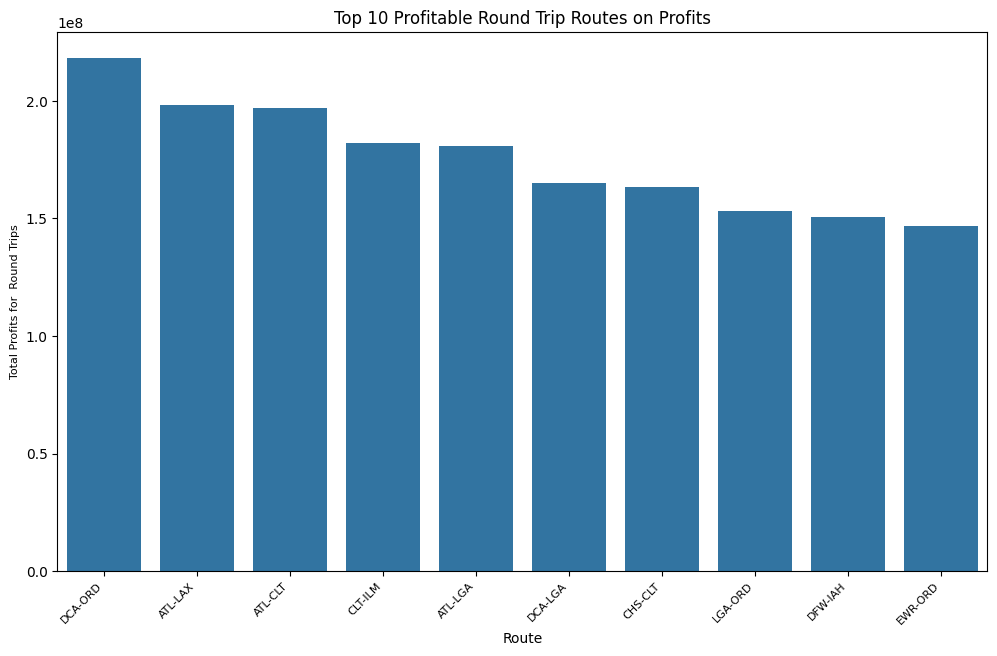

<class 'pandas.core.frame.DataFrame'>


,Normalized_ROUTE,TOTAL_REVENUE,TOTAL_COST,TOTAL_PROFIT,OCCUPANCY_RATE,DEP_DELAY,ARR_DELAY
1104,DCA-ORD,383699319.94,165343247.12,218356072.82,0.65,6.93,14.19
176,ATL-LAX,397004930.90,198926769.72,198078161.18,0.65,6.70,13.81
126,ATL-CLT,323998626.77,126813277.92,197185348.85,0.65,5.39,12.51
833,CLT-ILM,227901708.83,45688689.60,182213019.23,0.66,6.09,11.02
179,ATL-LGA,396139441.99,215478943.04,180660498.95,0.65,5.71,14.01
1088,DCA-LGA,286522677.36,121470117.84,165052559.52,0.65,6.82,15.31
728,CHS-CLT,226268943.92,62922346.00,163346597.92,0.65,5.80,10.48
2147,LGA-ORD,453936526.95,300606302.48,153330224.47,0.65,6.91,15.23
1272,DFW-IAH,265464329.55,114970212.32,150494117.23,0.65,5.90,10.14
1522,EWR-ORD,247174000.80,100494819.96,146679180.84,0.65,6.56,13.47


In [ ]:
def top_10_profitable_routes(df):

    # Aggregate data by normalized route
    route_summary = df.groupby('Normalized_ROUTE').agg(
        TOTAL_REVENUE=('TOTAL_REVENUE', 'sum'),
        TOTAL_COST=('TOTAL_COST', 'sum'),
        TOTAL_PROFIT=('TOTAL_PROFIT', 'sum'),
        OCCUPANCY_RATE=('OCCUPANCY_RATE', 'mean'),
        DEP_DELAY=('DEP_DELAY', 'mean'),
        ARR_DELAY=('ARR_DELAY', 'mean')
    ).reset_index()

    # Find the top 10 most profitable routes
    top_10_profitable_routes = route_summary.sort_values(by='TOTAL_PROFIT', ascending=False).head(10)

    #required coulmns in the data frame
    required_columns= ["Normalized_ROUTE","TOTAL_REVENUE","TOTAL_COST" ,"TOTAL_PROFIT","OCCUPANCY_RATE","DEP_DELAY","ARR_DELAY"]
    df_final = df [required_columns]


    # Creating the plot for top_10_profitable_routes
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(x='Normalized_ROUTE', y='TOTAL_PROFIT', data=top_10_profitable_routes)
    plt.title('Top 10 Profitable Round Trip Routes on Profits', fontsize=12)
    plt.xlabel('Route', fontsize=10)
    plt.ylabel('Total Profits for  Round Trips', fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.show()

    return top_10_profitable_routes, df_final

#Applying the function
top_10_profitable_routes= top_10_profitable_routes(df_flights_final)
top_10_profitable_routes=converting_dataframe(top_10_profitable_routes)
top_10_profitable_routes


##TOP 10 PROFITABLE ROUTES:

From the above graph it is clear that ATL-LGA satnds top in profits earned with $349358545.66 follwed by LGA-ORD and MSP-ORD stands in 10 th position with respect to profits. These routes can be considered while making a decison about the 5 round trips as profits are one of the very important objectives of the airline.


###3) The 5 round trip routes that you recommend to invest in based on any factors that you choose.The number of round trip flights it will take to breakeven on the upfront airplane cost for the round trip routes

In [ ]:

def recommended_routes(df, top_10_profitable_routes,top_10_busiest_routes):

    #Combining both profitable nad busiest routes
    combined_df = pd.concat([top_10_profitable_routes, top_10_busiest_routes], ignore_index=True, sort=False)
    combined_df=combined_df["Normalized_ROUTE"]

    # Ensure numbers are displayed in a more readable format
    pd.options.display.float_format = '{:.2f}'.format

    # filtering the required columns
    required_columns= ["Normalized_ROUTE","TOTAL_REVENUE","TOTAL_COST" ,"TOTAL_PROFIT","BREAK_EVEN","OCCUPANCY_RATE","DEP_DELAY","ARR_DELAY"]

    # Select the required columns from the main DataFrame
    df_recommended = df [required_columns]

    # Merge with the combined DataFrame on 'Normalized_ROUTE'
    required_df = pd.merge(df_recommended, combined_df, on="Normalized_ROUTE", how='inner')

    # Group by 'Normalized_ROUTE' and calculate required statistics
    route_summary = required_df.groupby('Normalized_ROUTE').agg(
        TOTAL_REVENUE=('TOTAL_REVENUE', 'sum'),
        TOTAL_COST=('TOTAL_COST', 'sum'),
        TOTAL_PROFIT=('TOTAL_PROFIT', 'sum'),
        BREAK_EVEN=('BREAK_EVEN', 'mean'),
        OCCUPANCY_RATE=('OCCUPANCY_RATE', 'mean'),
        DEP_DELAY=('DEP_DELAY', 'mean'),
        ARR_DELAY=('ARR_DELAY', 'mean')
    ).reset_index()

    return route_summary

#Applying the function
recommended_routes= recommended_routes(df_flights_final,top_10_profitable_routes,top_10_busiest_routes)
recommended_routes

,Normalized_ROUTE,TOTAL_REVENUE,TOTAL_COST,TOTAL_PROFIT,BREAK_EVEN,OCCUPANCY_RATE,DEP_DELAY,ARR_DELAY
0,ATL-CLT,323998626.77,126813277.92,197185348.85,4171.75,0.65,5.39,12.51
1,ATL-FLL,284433428.25,210655789.44,73777638.81,889143.08,0.65,5.47,10.41
2,ATL-LAX,397004930.90,198926769.72,198078161.18,13005.82,0.65,6.70,13.81
3,ATL-LGA,792278883.98,430957886.08,361320997.90,20987.82,0.65,5.71,14.01
4,ATL-MCO,295283770.56,205464016.40,89819754.16,101561.71,0.65,5.32,10.17
5,BOS-LGA,310391476.39,169547606.88,140843869.51,30150.16,0.65,7.30,16.29
6,CHS-CLT,226268943.92,62922346.00,163346597.92,2035.52,0.65,5.80,10.48
7,CLT-ILM,227901708.83,45688689.60,182213019.23,1665.93,0.66,6.09,11.02
8,DCA-LGA,286522677.36,121470117.84,165052559.52,6027.46,0.65,6.82,15.31
9,DCA-ORD,383699319.94,165343247.12,218356072.82,5369.22,0.65,6.93,14.19


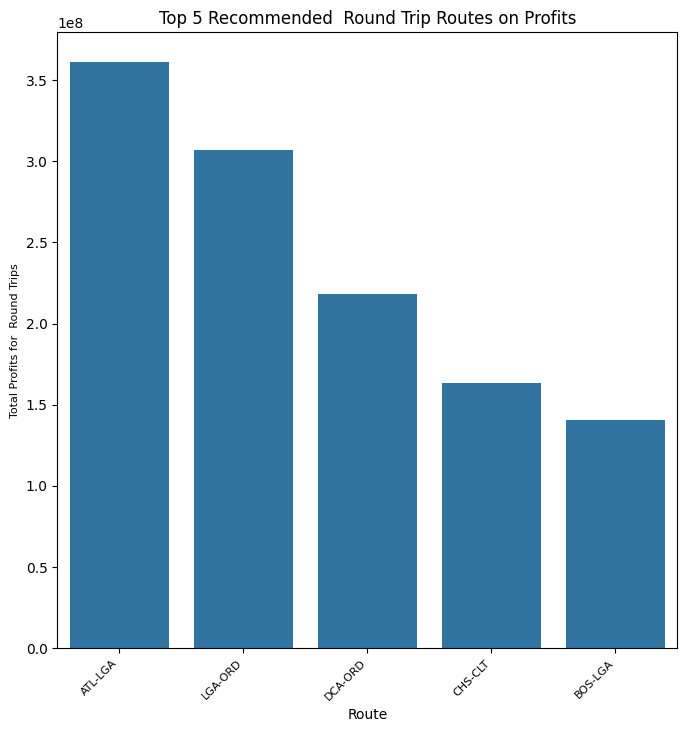

In [ ]:
top_5_recommended_routes= ["ATL-LGA","DCA-ORD","LGA-ORD", "CHS-CLT","BOS-LGA"]
selected_routes_df = recommended_routes.loc[recommended_routes['Normalized_ROUTE'].isin(top_5_recommended_routes)]
selected_routes_df_profits= selected_routes_df.sort_values(by='TOTAL_PROFIT', ascending=False)

# Creating the plot for top_recommended_routes
plt.figure(figsize=(8,8))
barplot = sns.barplot(x='Normalized_ROUTE', y='TOTAL_PROFIT', data=selected_routes_df_profits)
plt.title('Top 5 Recommended  Round Trip Routes on Profits', fontsize=12)
plt.xlabel('Route', fontsize=10)
plt.ylabel('Total Profits for  Round Trips', fontsize=8)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.show()







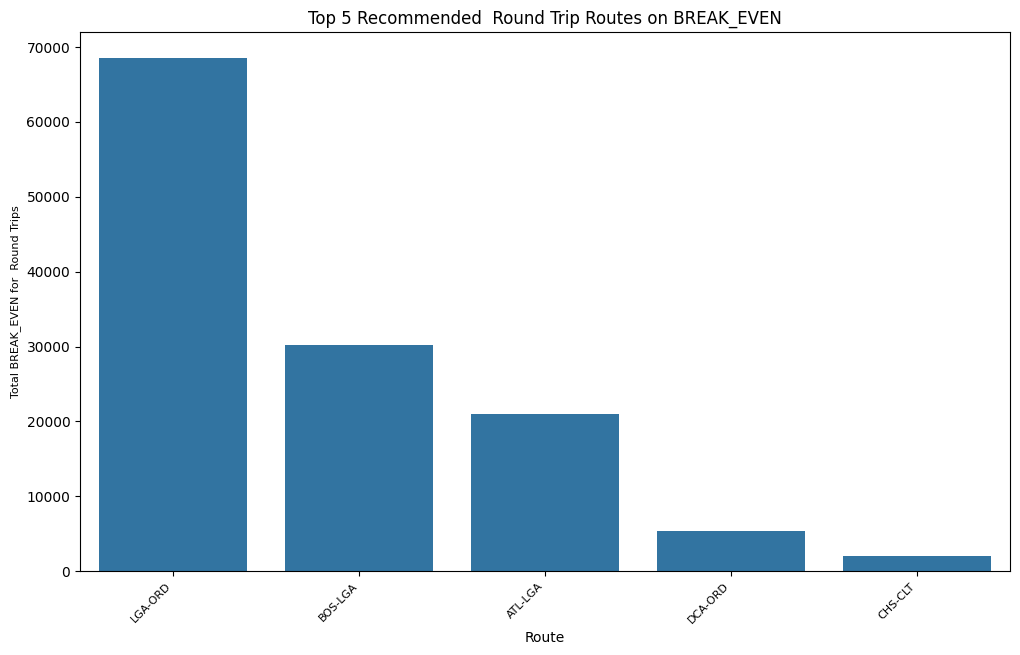

In [ ]:
# Creating the plot for top_recommended_routes
selected_routes_df_Breakeven= selected_routes_df.sort_values(by='BREAK_EVEN', ascending=False)
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='Normalized_ROUTE', y='BREAK_EVEN', data=selected_routes_df_Breakeven)
plt.title('Top 5 Recommended  Round Trip Routes on BREAK_EVEN', fontsize=12)
plt.xlabel('Route', fontsize=10)
plt.ylabel('Total BREAK_EVEN for  Round Trips', fontsize=8)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.show()

##Five Recommended Routes:

By considering factors like total_profit,Break even,occupancy rate and delays the five recommended routes would be  ATL-LGA,DCA-ORD, LGA-ORD, MSP-ORD,BOS-LGA.These routes not only considers the financial perspective  but also considers brand Image by considering delays, Operational Effiency by considering Break even etc

##DATA QUALITY ISSUES:
1) Missing  IATA CODES in the airports data set- IATA CODES for some Medium and Large airports are missing. Due to lack of information about these codes, they have to be removed from the data set.Thius may cause some changes in the anlaysis which might results in wrong conclusions.

2) INCONSISTENT DATA- There are columns with values of different data types are entered.This later have caused distrubance in the process. For example, some column like ITIN FARE have some string values that are later converted into numeric for performing furture analysis.

3) NEGATIVE VALUES IN DELAY ColMNS- There are negative values in arrival delay and departure delay columns which are not clear. This data when used can alter the whole anlaysisfrom the one it should be.

##KEY PERFORMANCE INDICATORS

The Key Performance Indicatores would be:

1) On-Time Departure and Arrival Rates: Since the company motto primaraly focuses on Punctuality, On time Departure and On time arrival should be one of teh KPIs. Tracking this KPI would help teh company improce its Brand Loyality and Customer Satisfaction.

2) PROFITS: As any business, Maximing profits should be one of the primary objectives. Also, tracking profits also include Tracking Revenues and costs associated with such profits.This KPI shoe cases the comapny Financial performance anf effiency .

3) OCCUPANCY RATE- This rate talks about no of seats filled out of total capacity. Higher the Rate higher would be returns.Tracking this KPI helps us to know the operational effiency and capacity maximization of the airline

4) CUSTOMER SATISFACTION INDEX- This KPI measures how satisfied the customers are travelling through our airlines.As the company is new to US airline Market, customer satisfaction would bring them back to the airline and spread good word of mouth about the airline,

5) BREAK-EVEN_FACTOR- This KPI talks about minimum load Factor required for the company to be in no loss nad no profit situation.Tracking KPI helps to know hoe efficient teh opeartions are at the airlines.

###RECOMMENDATIONS
 As a Data anlayst after anlasying the above data i would recommend:

 1) Invest in the above recommended routes- Investing in these routes can be profitable to teh airlines. These routes were recommended after considering factors like occupancy rate, delay time, Break even which also ensures Operational effiency and Optmizing the capacity utilization.

 2) Ensure Puntuality for every trip- As mentioned puntuality being the top among all the objectives, ensures flights depart and arrive without delay would definetly postion the brand among the competitors. Also,ensuring this can attract more customers who are on business travels as well.

 3) Sustainable Travels- Sustainabilty being the trend and will continue to be teh new trend. Implementing Sustainable intiatives like reducing fuel consumption techniques, more usage of sustainable products etc would potary a image to its customers that the airline is enviroment friendly.

 4) Conduct customer surveys and reviews- Asking the passengers to fill in the customer review forms after the flight would give teh airline siginificant imputs on areas of improvement and know how satisfied the customers are.

 5) Conduct Market research in US- By Conducting market reaserch the airlines can know how the market is, what are its areas of strengths and weakness, how it can postion itself in the US AIRLINE INDUSTRY.

##CONCLUSION:

After analyzing the airlinedata sets, my findings spotlight several key routes that hold promising funding opportunities for the growth into the U.S. Domestic marketplace. The recommended routes — ATL-LGA","DCA-ORD","LGA-ORD", "CHS-CLT","BOS-LGA"— show off huge profitability and operational performance, with excessive general earnings and affordable destroy-even factors. These routes not simplest satisfy the enterprise’s emphasis on punctuality but additionally promise rapid returns on investment, showcasing less than common postpone instances which align with our motto "On time, for you". Moving ahead, I suggest monitoring KPIs which include occupancy fee, on-time overall performance, and consumer delight to make sure sustained boom and operational success. Additionally, investing in sustainable practices and enhancing customer revel in through non-stop feedback will similarly beef up our market role and logo reputation.